In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

from catboost import CatBoostClassifier
import time

In [2]:
train_data = pd.read_csv('../pre_data/pre_training.csv')
train_data

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,cabin_deck,cabin_num,cabin_side
0,0001_01,Europa,0,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0,B,0.0,P
1,0002_01,Earth,0,TRAPPIST-1e,24.0,0.0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1,F,0.0,S
2,0003_01,Europa,0,TRAPPIST-1e,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0,A,0.0,S
3,0003_02,Europa,0,TRAPPIST-1e,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0,A,0.0,S
4,0004_01,Earth,0,TRAPPIST-1e,16.0,0.0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1,F,1.0,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,0,55 Cancri e,41.0,1.0,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,0,A,98.0,P
8689,9278_01,Earth,1,PSO J318.5-22,18.0,0.0,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,0,G,1499.0,S
8690,9279_01,Earth,0,TRAPPIST-1e,26.0,0.0,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,1,G,1500.0,S
8691,9280_01,Europa,0,55 Cancri e,32.0,0.0,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,0,E,608.0,S


In [3]:
test_data = pd.read_csv('../pre_data/pre_test.csv')
test_data

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,cabin_deck,cabin_num,cabin_side
0,0013_01,Earth,1,TRAPPIST-1e,27.0,0.0,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,G,3.0,S
1,0018_01,Earth,0,TRAPPIST-1e,19.0,0.0,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,F,4.0,S
2,0019_01,Europa,1,55 Cancri e,31.0,0.0,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,C,0.0,S
3,0021_01,Europa,0,TRAPPIST-1e,38.0,0.0,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter,C,1.0,S
4,0023_01,Earth,0,TRAPPIST-1e,20.0,0.0,10.0,0.0,635.0,0.0,0.0,Brence Harperez,F,5.0,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,1,TRAPPIST-1e,34.0,0.0,0.0,0.0,0.0,0.0,0.0,Jeron Peter,G,1496.0,S
4273,9269_01,Earth,0,TRAPPIST-1e,42.0,0.0,0.0,847.0,17.0,10.0,144.0,Matty Scheron,G,1044.0,S
4274,9271_01,Mars,1,55 Cancri e,26.0,0.0,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,D,296.0,P
4275,9273_01,Europa,0,55 Cancri e,26.0,0.0,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,D,297.0,P


In [4]:
for df in [train_data, test_data]:
    df["VIP"] = df["VIP"].astype(str).str.lower().map({
        "true": 1.0,
        "false": 0.0,
        "1": 1.0,
        "0": 0.0,
        "1.0": 1.0,
        "0.0": 0.0
    }).fillna(0.0).astype(float)

train_data = train_data.drop(columns='Name')
test_data = test_data.drop(columns='Name')

In [5]:
categorical_cols = ['HomePlanet', 'Destination', 'cabin_deck', 'cabin_side']

In [6]:
all_data = pd.concat([train_data, test_data], axis=0)

all_data = pd.get_dummies(all_data, columns=categorical_cols, drop_first=False)

dummy_cols = [col for col in all_data.columns if any(cat in col for cat in categorical_cols)]

all_data[dummy_cols] = all_data[dummy_cols].astype(float)


train_data = all_data.iloc[:len(train_data), :].copy()
test_data  = all_data.iloc[len(train_data):, :].copy()

In [7]:
from numpy import log1p

# ---------- TOTAL SPENDING ----------
train_data["TotalSpent"] = (
    train_data["RoomService"] +
    train_data["FoodCourt"] +
    train_data["ShoppingMall"] +
    train_data["Spa"] +
    train_data["VRDeck"]
)

test_data["TotalSpent"] = (
    test_data["RoomService"] +
    test_data["FoodCourt"] +
    test_data["ShoppingMall"] +
    test_data["Spa"] +
    test_data["VRDeck"]
)

# ---------- TOTAL SPENDING ----------
train_data["TotalSpent_log1p"] = log1p(
    (
    train_data["RoomService"] +
    train_data["FoodCourt"] +
    train_data["ShoppingMall"] +
    train_data["Spa"] +
    train_data["VRDeck"]
)
)

test_data["TotalSpent_log1p"] = log1p(
    (
    test_data["RoomService"] +
    test_data["FoodCourt"] +
    test_data["ShoppingMall"] +
    test_data["Spa"] +
    test_data["VRDeck"]
)
)


#--------------------------------------------------------------------------------------#
train_data['spa_log1p'] = log1p(train_data['Spa'] + train_data['VRDeck'])
test_data['spa_log1p'] = log1p(test_data['Spa'] + test_data['VRDeck'])

train_data['cabin_log'] = log1p(train_data['cabin_num'] + train_data['Spa'])
test_data['cabin_log'] = log1p(test_data['cabin_num'] + test_data['Spa'])

train_data['cabin_log_vr'] = log1p(train_data['cabin_num'] + train_data['FoodCourt'])
test_data['cabin_log_vr'] = log1p(test_data['cabin_num'] + test_data['FoodCourt'])

train_data['rooms_plus_food'] = log1p(train_data['RoomService'] + train_data['FoodCourt'])
test_data['rooms_plus_food'] = log1p(test_data['RoomService'] + test_data['FoodCourt'])

train_data['food_log_1'] = log1p(train_data['FoodCourt'] + train_data['ShoppingMall'])
test_data['food_log_1'] = log1p(test_data['FoodCourt'] + test_data['ShoppingMall'])

train_data["TotalSpent_bin"] = pd.cut(train_data["TotalSpent_log1p"], bins=5, labels=False)
test_data["TotalSpent_bin"] = pd.cut(test_data["TotalSpent_log1p"], bins=5, labels=False)

#---------------------------------------------------------------------------------------#
train_data = train_data.drop(columns=['VIP', 'CryoSleep', 'TotalSpent', 'Age'])
test_data = test_data.drop(columns=['VIP', 'CryoSleep', 'TotalSpent', 'Age'])

In [8]:
categorical_cols = ['TotalSpent_bin']

psg_id = train_data['PassengerId']
train_data = train_data.drop(columns='PassengerId')

In [9]:
f1, f2 = 'TotalSpent_bin', 'food_log_1'

train_data[[f1, f2]] = train_data[[f1, f2]].fillna(train_data[[f1, f2]].median())
test_data[[f1, f2]] = test_data[[f1, f2]].fillna(train_data[[f1, f2]].median())

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(train_data[[f1, f2]])

train_data['cluster'] = kmeans.labels_
test_data['cluster'] = kmeans.predict(test_data[[f1, f2]])

In [10]:
train_data

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,cabin_num,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,...,cabin_side_P,cabin_side_S,TotalSpent_log1p,spa_log1p,cabin_log,cabin_log_vr,rooms_plus_food,food_log_1,TotalSpent_bin,cluster
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1
1,109.0,9.0,25.0,549.0,44.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,6.602588,6.386879,6.309918,2.302585,4.779123,3.555348,3.0,2
2,43.0,3576.0,0.0,6715.0,49.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,9.248021,8.819518,8.812248,8.182280,8.194229,8.182280,4.0,0
3,0.0,1283.0,371.0,3329.0,193.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,8.551981,8.167068,8.110728,7.157735,7.157735,7.411556,4.0,0
4,303.0,70.0,151.0,565.0,2.0,1.0,1.0,1.0,0.0,0.0,...,0.0,1.0,6.995766,6.342121,6.340359,4.276666,5.924256,5.402677,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,0.0,6819.0,0.0,1643.0,74.0,0.0,98.0,0.0,1.0,0.0,...,1.0,0.0,9.052165,7.448916,7.462789,8.841882,8.827615,8.827615,4.0,0
8689,0.0,0.0,0.0,0.0,0.0,0.0,1499.0,1.0,0.0,0.0,...,0.0,1.0,0.000000,0.000000,7.313220,7.313220,0.000000,0.000000,0.0,1
8690,0.0,0.0,1872.0,1.0,0.0,1.0,1500.0,1.0,0.0,0.0,...,0.0,1.0,7.535830,0.693147,7.314553,7.313887,0.000000,7.535297,3.0,0
8691,0.0,1049.0,0.0,353.0,3235.0,0.0,608.0,0.0,1.0,0.0,...,0.0,1.0,8.442039,8.185629,6.869014,7.413367,6.956545,6.956545,4.0,0


In [11]:
test_data

,PassengerId,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,cabin_num,HomePlanet_Earth,HomePlanet_Europa,...,cabin_side_P,cabin_side_S,TotalSpent_log1p,spa_log1p,cabin_log,cabin_log_vr,rooms_plus_food,food_log_1,TotalSpent_bin,cluster
0,0013_01,0.0,0.0,0.0,0.0,0.0,NaN,3.0,1.0,0.0,...,0.0,1.0,0.000000,0.000000,1.386294,1.386294,0.000000,0.000000,0.0,1
1,0018_01,0.0,9.0,0.0,2823.0,0.0,NaN,4.0,1.0,0.0,...,0.0,1.0,7.949091,7.945910,7.947325,2.639057,2.302585,2.302585,3.0,2
2,0019_01,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,1.0,...,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1
3,0021_01,0.0,6652.0,0.0,181.0,585.0,NaN,1.0,0.0,1.0,...,0.0,1.0,8.911800,6.642487,5.209486,8.802973,8.802823,8.802823,4.0,0
4,0023_01,10.0,0.0,635.0,0.0,0.0,NaN,5.0,1.0,0.0,...,0.0,1.0,6.470800,0.000000,1.791759,1.791759,2.397895,6.455199,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,0.0,0.0,0.0,0.0,0.0,NaN,1496.0,1.0,0.0,...,0.0,1.0,0.000000,0.000000,7.311218,7.311218,0.000000,0.000000,0.0,1
4273,9269_01,0.0,847.0,17.0,10.0,144.0,NaN,1044.0,1.0,0.0,...,0.0,1.0,6.926577,5.043425,6.961296,7.545390,6.742881,6.762730,3.0,0
4274,9271_01,0.0,0.0,0.0,0.0,0.0,NaN,296.0,0.0,0.0,...,1.0,0.0,0.000000,0.000000,5.693732,5.693732,0.000000,0.000000,0.0,1
4275,9273_01,0.0,2680.0,0.0,0.0,523.0,NaN,297.0,0.0,1.0,...,1.0,0.0,8.072155,6.261492,5.697093,7.999007,7.893945,7.893945,3.0,0


In [12]:
test_data = test_data.drop(columns='Transported', errors='ignore')

In [13]:
X = train_data.drop("Transported", axis=1)

y = train_data["Transported"]


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.08, random_state=42)

In [15]:
model = CatBoostClassifier(
    iterations=2250,
    learning_rate=0.018,
    depth=6,
    random_state=42,
    auto_class_weights='Balanced',
)

In [16]:
model.fit(X_train, y_train)

0:	learn: 0.6841454	total: 146ms	remaining: 5m 27s
1:	learn: 0.6756839	total: 148ms	remaining: 2m 46s
2:	learn: 0.6661668	total: 150ms	remaining: 1m 52s
3:	learn: 0.6581387	total: 153ms	remaining: 1m 25s
4:	learn: 0.6506390	total: 155ms	remaining: 1m 9s
5:	learn: 0.6432898	total: 157ms	remaining: 58.7s
6:	learn: 0.6362714	total: 159ms	remaining: 51s
7:	learn: 0.6292669	total: 161ms	remaining: 45.2s
8:	learn: 0.6228170	total: 164ms	remaining: 40.7s
9:	learn: 0.6163455	total: 166ms	remaining: 37.1s
10:	learn: 0.6098043	total: 168ms	remaining: 34.1s
11:	learn: 0.6041849	total: 170ms	remaining: 31.7s
12:	learn: 0.5989046	total: 172ms	remaining: 29.6s
13:	learn: 0.5936266	total: 175ms	remaining: 27.9s
14:	learn: 0.5884650	total: 177ms	remaining: 26.3s
15:	learn: 0.5836823	total: 179ms	remaining: 25s
16:	learn: 0.5789054	total: 181ms	remaining: 23.8s
17:	learn: 0.5740818	total: 184ms	remaining: 22.8s
18:	learn: 0.5699003	total: 186ms	remaining: 21.8s
19:	learn: 0.5651270	total: 188ms	remaini

In [17]:
model.score(X_test, y_test)

np.float64(0.8318965517241379)

In [18]:
psg_id_test = test_data["PassengerId"]

In [19]:
test_data = test_data.drop(columns="PassengerId", errors="ignore")

In [20]:
pred = model.predict(test_data)

In [21]:
submission = pd.DataFrame({
    "PassengerId": psg_id_test,
    "Transported": pred.astype(bool)
})

submission.to_csv("submission.csv", index=False)

In [22]:
imp = model.get_feature_importance()

f_imp = pd.DataFrame({
    'Feature': X.columns,
    'Importance': imp
}).sort_values('Importance', ascending=False)

f_imp.head(30)

,Feature,Importance
23,spa_log1p,10.654222
22,TotalSpent_log1p,9.927057
5,cabin_num,8.693091
27,food_log_1,6.736794
24,cabin_log,6.517790
0,RoomService,5.133666
6,HomePlanet_Earth,4.679211
25,cabin_log_vr,4.604024
28,TotalSpent_bin,3.919731
4,VRDeck,3.791816


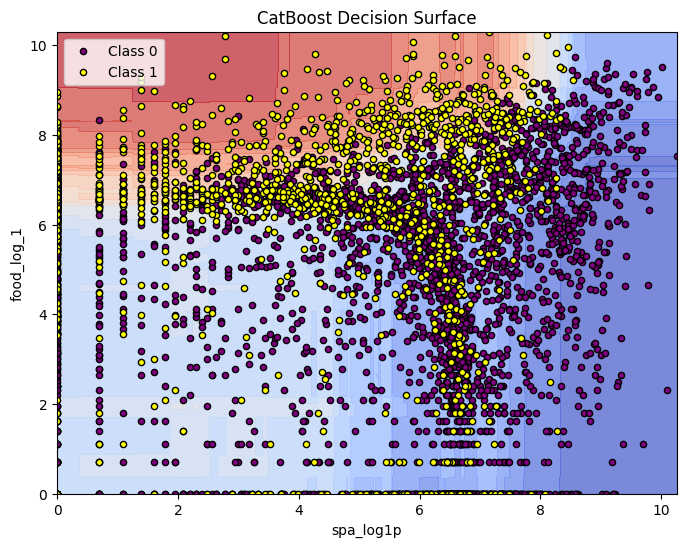

In [23]:
f1, f2 = 'spa_log1p', 'food_log_1'

model_features = model.feature_names_

x_min, x_max = X[f1].min(), X[f1].max()
y_min, y_max = X[f2].min(), X[f2].max()

xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)

n_points = xx.size

grid_df = pd.DataFrame(columns=model_features)

for col in model_features:
    if col in X.columns:
        grid_df[col] = [X[col].median()] * n_points
    else:
        grid_df[col] = 0

grid_df[f1] = xx.ravel()
grid_df[f2] = yy.ravel()

probs = model.predict_proba(grid_df)[:, 1].reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, probs, levels=20, alpha=0.7, cmap='coolwarm')

# scatter по класове
plt.scatter(X[f1][y == 0], X[f2][y == 0], c='purple', edgecolor='k', s=20, label='Class 0')
plt.scatter(X[f1][y == 1], X[f2][y == 1], c='yellow', edgecolor='k', s=20, label='Class 1')

plt.xlabel(f1)
plt.ylabel(f2)
plt.title("CatBoost Decision Surface")
plt.legend()
plt.show()